In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
#Sept 6-20 Dates to choose
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation')

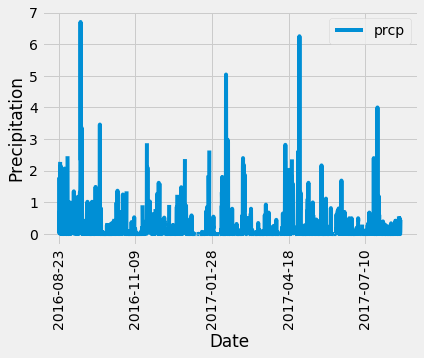

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Aug 23, 2017
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
hawaii_results = session.query(measure.date, measure.prcp).filter(measure.date >= last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
hawaii_trip = pd.DataFrame(hawaii_results, columns = ['date', 'prcp'])

#hawaii_trip.head()

# Sort the dataframe by date
hawaii_trip = hawaii_trip.sort_values("date")
hawaii_trip.set_index(hawaii_trip['date'], inplace = True)
# Use Pandas Plotting with Matplotlib to plot the data
hawaii_trip.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_trip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measure.station, func.count(measure.station)).group_by(measure.station).order_by(func.count(measure.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measure.station, func.min(measure.tobs), func.max(measure.tobs), func.avg(measure.tobs)).filter(measure.station=='USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

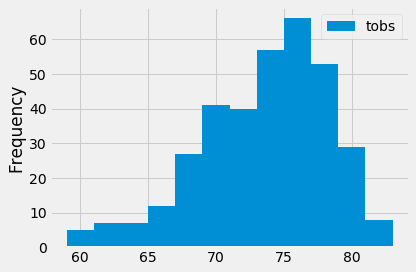

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#needs to go to my app.py
# @app.route('/<date>')
# def index(date):
#   if date=='about':
#      return render_template('about.html') # for example
#   else:
#      some_value = do_something_with_date(date) # for example
#      return render_template('index.html', my_param=some_value)
session_results = session.query(measure.tobs).filter(measure.station=='USC00519281').filter(measure.date >=last_year).all()
session_results_df = pd.DataFrame(session_results, columns=["tobs"])
session_results_df.plot.hist(bins=12)
plt.tight_layout()
#('USC00519281', 2772),


## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measure.tobs), func.avg(measure.tobs), func.max(measure.tobs)).\
        filter(measure.date >= start_date).filter(measure.date <= end_date).all()

# function usage example
print(calc_temps('2016-09-06', '2016-09-20'))

[(70.0, 77.12631578947368, 83.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measure.tobs), func.avg(measure.tobs), func.max(measure.tobs)).filter(measure.date >= start_date).filter(measure.date <= end_date).all()

# function usage example
print(calc_temps('2015-09-06', '2015-09-20'))

[(71.0, 78.6063829787234, 85.0)]


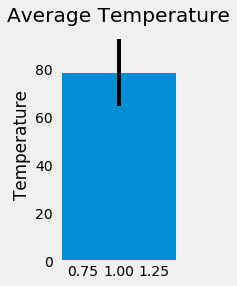

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = 85
tmin = 71
tavg = 78.6063829787234
difftemp = tmax - tmin

plt.figure(figsize=(2, 4))
plt.bar(1, tavg, yerr=difftemp)
plt.ylabel('Temperature')
plt.title('Average Temperature')
plt.grid()
plt.show()


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

req_columns = [measure.station, measure.prcp, station.name, station.longitude, station.latitude, station.elevation]

last_year_rain_data = session.query(*req_columns).filter(measure.date <= last_year).group_by(station.name).order_by(measure.prcp).all()

last_year_rain_data 



[('USC00519397',
  0.08,
  'HONOLULU OBSERVATORY 702.2, HI US',
  -157.9992,
  21.3152,
  0.9),
 ('USC00519397', 0.08, 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6),
 ('USC00519397',
  0.08,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00519397',
  0.08,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519397', 0.08, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9),
 ('USC00519397',
  0.08,
  'UPPER WAHIAWA 874.3, HI US',
  -158.0111,
  21.4992,
  306.6),
 ('USC00519397',
  0.08,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00519397', 0.08, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0),
 ('USC00519397',
  0.08,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5)]

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measure.tobs), func.avg(measure.tobs), func.max(measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
